In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 12.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.9 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
     |████████████████████████████████| 895 kB 41.3 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
cd /content/drive/MyDrive/CSCI544/PROJECT

/content/drive/MyDrive/CSCI544/PROJECT


In [2]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import datetime
import os

In [ ]:
# global variables 
gender_words = set(['woman', 'women', 'female', 'she', 'her', 'hers', 'man', 'men', 'male', 'he', 'his', 'him'])
MAX_LEN = 128

In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

# Load Data

In [3]:
# load data sets 
train = pd.read_csv("data/train.csv")
validation = pd.read_csv("data/validation.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
train_x, train_y = train["text"], train["gender"]
val_x, val_y = validation["text"], validation["gender"]
test_x, test_y = test["text"], test["gender"]

In [7]:
len(train[train["gender"]==0])/len(train)

0.19048429363917913

# Tokenize the data using BERT's tokenizer 

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# tokenize the data 

def tokenizeData(data, tokenizer, MAX_LEN): 
    """
    Use BEERT's tokenizer to tokenize the data, and mask the gendr words 
    return the tokenized and padded to MAX_LEN
    also return the attension masks 

    """
    sentences = [[x if x not in gender_words else "[MASK]" for x in sent] for sent in data]
    input_ids = []
    attention_masks = []
    for sent in sentences: 
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.                   
        )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

In [ ]:
#tokenize train_x, val_x and test_x
train_x, train_mask = tokenizeData(train_x, tokenizer, MAX_LEN = MAX_LEN)
val_x, val_mask = tokenizeData(val_x, tokenizer, MAX_LEN = MAX_LEN)
#test_x, test_mask = tokenizeData(test_x, tokenizer, MAX_LEN = MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# convert labels into tensoirs 
train_y = torch.tensor(train_y)
val_y = torch.tensor(val_y)

In [ ]:
# create data set 
train_data = TensorDataset(train_x, train_mask, train_y)
val_data = TensorDataset(val_x, val_mask, val_y)
#test_data = TensorDataset(test_x, test_mask, test_y)

In [ ]:
# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Load the pre-trained bert model 


In [5]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# training loop 

In [ ]:
# helper function to claculkate accuracy 
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# helper function to calculate time 
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# helper function to save the model weight; s and tokenizer 
def saveModel(model, tokenizer, output_dir): 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print("Saving model to {}".format(output_dir))
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print("Done!")
    

In [ ]:
# optimizer and learning rate scheduler 
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), 
                lr = 1e-5, 
                eps = 1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
# training loop 
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.6f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # save the model 
    saveModel(model, tokenizer, "epoch_{}".format(epoch_i+1))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of    919.    Elapsed: 0:00:21.
  Batch   200  of    919.    Elapsed: 0:00:42.
  Batch   300  of    919.    Elapsed: 0:01:02.
  Batch   400  of    919.    Elapsed: 0:01:23.
  Batch   500  of    919.    Elapsed: 0:01:44.
  Batch   600  of    919.    Elapsed: 0:02:05.
  Batch   700  of    919.    Elapsed: 0:02:26.
  Batch   800  of    919.    Elapsed: 0:02:46.
  Batch   900  of    919.    Elapsed: 0:03:07.

  Average training loss: 0.146814
  Training epcoh took: 0:03:11

Running Validation...
  Accuracy: 0.9822
  Validation Loss: 0.04
  Validation took: 0:00:25
Saving model to epoch_1
Done!

======== Epoch 2 / 4 ========
Training...
  Batch   100  of    919.    Elapsed: 0:00:21.
  Batch   200  of    919.    Elapsed: 0:00:42.
  Batch   300  of    919.    Elapsed: 0:01:02.
  Batch   400  of    919.    Elapsed: 0:01:23.
  Batch   500  of    919.    Elapsed: 0:01:44.
  Batch   600  of    919.    Elapsed: 0:02:05.
  Batch   700  of   

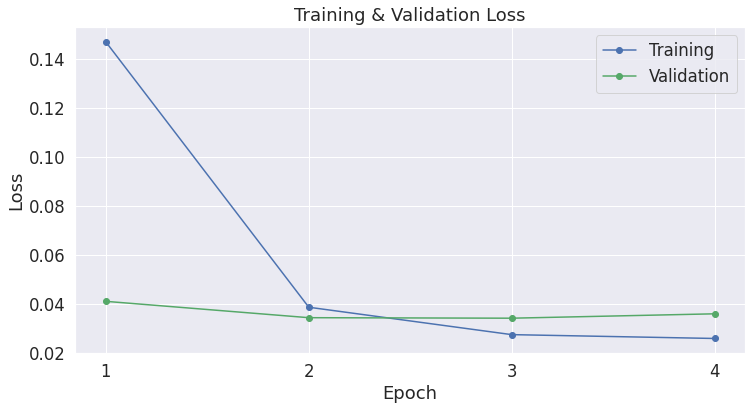

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.146814,0.041065,0.982154,0:03:11,0:00:25
2,0.038663,0.034400,0.988420,0:03:11,0:00:25
3,0.027494,0.034195,0.988579,0:03:11,0:00:25
4,0.025928,0.035982,0.987627,0:03:11,0:00:25


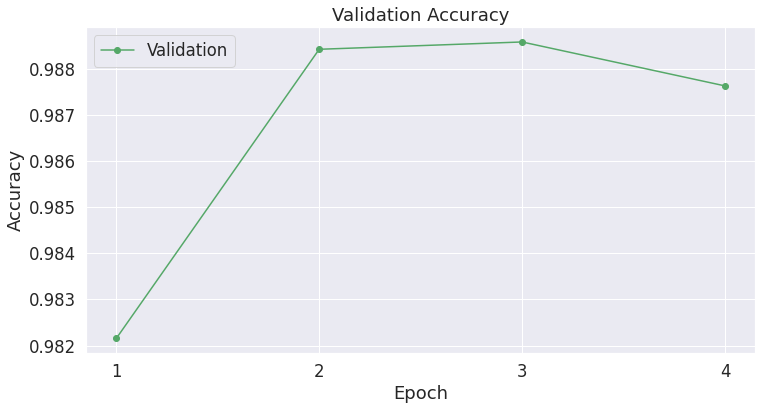

In [ ]:
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Load the test set and calculate the accuracy 


In [ ]:
ls

 data/                   epoch_1/   epoch_4/       training.ipynb
 DataCleaning.ipynb      epoch_2/  'firs train'/
 data_processing.ipynb   epoch_3/   test/


In [4]:
# load model 
model = BertForSequenceClassification.from_pretrained("epoch_3")
tokenizer = BertTokenizer.from_pretrained("epoch_3")

NameError: ignored

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
test_x, test_mask = tokenizeData(test_x, tokenizer, MAX_LEN = MAX_LEN)
test_y = torch.tensor(test_y)
test_data = TensorDataset(test_x, test_mask, test_y)
test_loader = DataLoader(test_data, batch_size=4000)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.eval()
predictions = []
ground_truth = []
for batch in test_loader: 
    # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  ground_truth.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
np.save("test_prediction_pretrained.npy", predictions[0])

In [ ]:
np.save("test_labels.npy", ground_truth[0])

In [ ]:
pred = [np.argmax(x) for x in predictions[0]]

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_curve, precision_score, recall_score
confusion_matrix = confusion_matrix(ground_truth[0], pred)

In [ ]:
confusion_matrix

array([[2000,    0],
       [2000,    0]])

In [ ]:
f1 = f1_score(ground_truth[0], pred)

In [ ]:
precision = precision_score(ground_truth[0], pred)
recall = recall_score(ground_truth[0], pred)

In [ ]:
print(f1, precision, recall)

0.9794117647058823 0.9605769230769231 0.999
